# <span style='color:blue'> Analysis of feature importance and performance by group compound for classifier M5</span>

The present `Jupyter Notebook` contains the analysis of feature importance by SHAP theory of classifier M5.

## Import Essentials

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle
import shap

from scipy import stats

from sklearn.metrics import f1_score

In [2]:
# Import functions from customized modules
from Scripts.preprocessing import feature_filt, feature_filt_adv

## Define file names

In [3]:
# File names and sheet names
descriptors_file = './Data/BTZs_full_descriptors_final.xlsx'
data_matrix = 'general_data_matrix'
desc = 'descriptors'
model = './Results/M5.pkl'
shap_output = './Results/shap_values_M5.csv'

## Load data  

In [4]:
# Load data set with SMILES
BTZs = pd.read_excel(descriptors_file, sheet_name=data_matrix)

# Load set of descriptors 
desc = pd.read_excel(descriptors_file, sheet_name=desc)

In [5]:
# Create X data sets from descriptors and molecular fingerprints
Xdesc = desc.iloc[:, 1:] 
print('X descriptors shape {}'.format(Xdesc.shape))

X descriptors shape (96, 227)


In [6]:
y = BTZs.Class

print('y shape {}'.format(y.shape))

y shape (96,)


## Load model

In [7]:
# Load the model previously saved
with open(model, 'rb') as file:
    model_M5 = pickle.load(file)    

## SHAP for M5

In [8]:
# Define training/test sets 
X_train31, X_test31, y_train31, y_test31 = feature_filt(Xdesc, y, 0.25, 31)
# Train the model
model_M5.fit(X_train31, y_train31)

# Define explainer 
explainer_M5 = shap.KernelExplainer(model_M5.predict, X_train31)
# Calculate SHAP values
shap_values_M5 = explainer_M5.shap_values(X_train31)

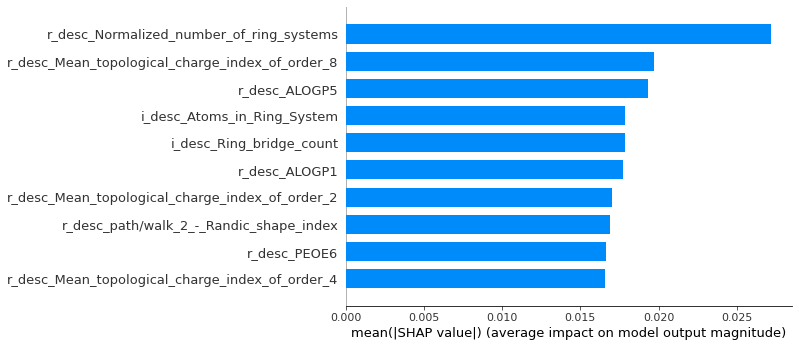

In [9]:
# Plot the results in bar type using the integrated feature in SHAP
shap.summary_plot(shap_values_M5, X_train31, feature_names=X_train31.columns, plot_type='bar', max_display=10)

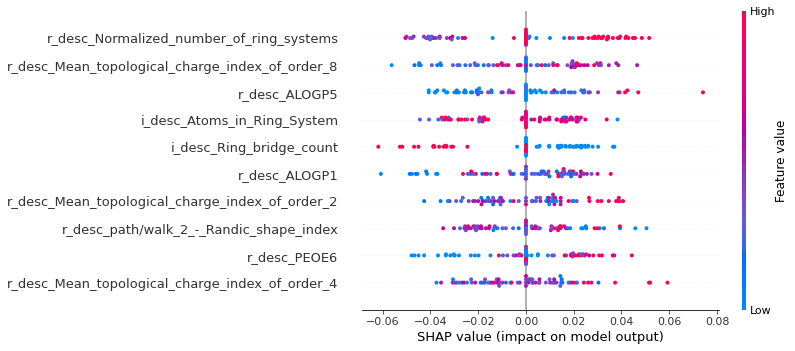

In [10]:
# Plot summary using integrated feature in SHAP
shap.summary_plot(shap_values_M5, X_train31, feature_names=X_train31.columns, max_display=10)

In [11]:
# Store SHAP values in DataFrame
shap_M5_df = pd.DataFrame(shap_values_M5, columns=X_train31.columns)
# Save SHAP values
shap_M5_df.to_csv(shap_output)

For further analysis, the mean absolute SHAP values are calculated and the samples separated according activity class

In [12]:
# Create a reduced data set only with mean absolute values
shap_for_plot = shap_values_M5.abs().mean(axis=0).sort_values(ascending=False)

In [13]:
# Correct index for training data
X_train31a = X_train31.copy()
X_train31a.set_index(y_train31.index, inplace=True)

In [14]:
# Split training data set into actives and inactives
pos31 = X_train31a.loc[:, shap_for_plot.index[:10]].filter(items=y_train31[y_train31==1].index, axis=0)
neg31 = X_train31a.loc[:, shap_for_plot.index[:10]].filter(items=y_train31[y_train31==0].index, axis=0)

In [15]:
# Define feature names for plot (if too large, split in two lines)
feature_names2 = []
for i in shap_for_plot.index[:10]:
    if len(i) > 20:
        br = i.count('_') // 2
        p = i.split('_')
        ibr = i.find(p[br])
        s1 = i[:ibr]
        s2 = i[ibr:]
        feature_names2.append(s1 + '\n' + s2)
    else:
        feature_names2.append(i)

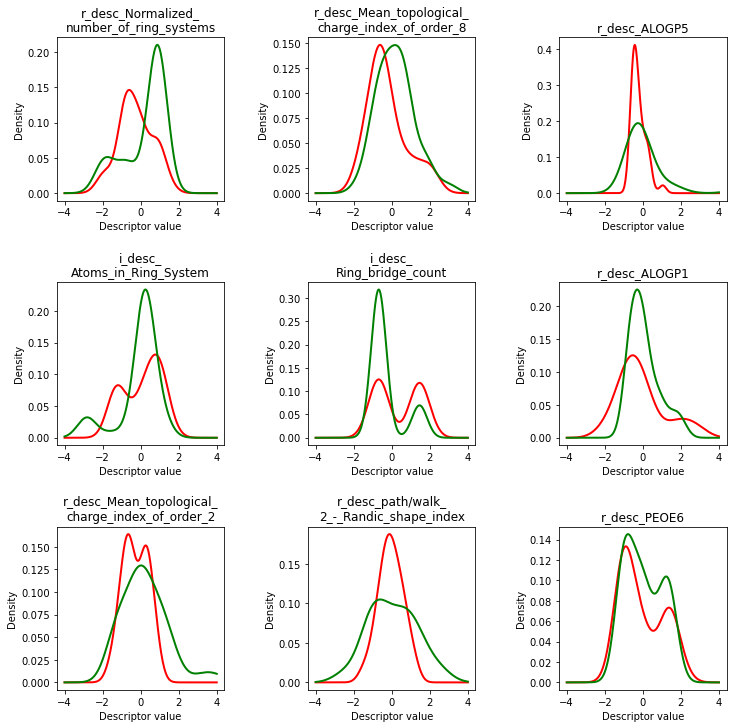

In [16]:
# Create a figure of feature distribution for the top ten features for both potent and non-potent compounds

fig, axs = plt.subplots(3, 3, figsize=(12, 12))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

axs = axs.ravel()

# Iterate over top features and plot distributions for actives and inactives
for i in range(9):
    xx = np.linspace(-4, 4, len(neg31[neg31.columns[i]]) * 10)
    kde = stats.gaussian_kde(neg31[neg31.columns[i]])
    axs[i].plot(xx, kde(xx) * len(neg31[neg31.columns[i]]) / 100, linewidth=2, color='r')

    xx = np.linspace(-4, 4, len(pos31[pos31.columns[i]]) * 10)
    kde = stats.gaussian_kde(pos31[pos31.columns[i]])
    axs[i].plot(xx, kde(xx) * len(pos31[pos31.columns[i]]) / 100, linewidth=2, color='g')
    
    axs[i].set_title(feature_names2[i])
    axs[i].set_xlabel('Descriptor value')
    axs[i].set_ylabel('Density')


plt.show()

### Performance of M5 for each compound group 

In [17]:
# Apply transformation retrieving the scaler 
X_train31, X_test31, y_train31, y_test31, scaler31 = feature_filt_adv(Xdesc, y, 0.25, 31)

In [18]:
# Use the scaler for the pretreatment of the new data set
Xall = Xdesc[X_train31.columns]
Xall_scaled31 = scaler31.transform(Xall)
Xall_scaled31 = pd.DataFrame(Xall_scaled31, columns=X_train31.columns)

In [19]:
# Predictions by model rf31

# Fit
model_M5.fit(X_train31, y_train31)
# Make predictions
ypred_all_rf31 = model_M5.predict(Xall_scaled31)

In [20]:
# Create a matrix with all the information for comparison purposes
comparison = BTZs.copy()
comparison['predicted'] = ypred_all_rf31

l = []
for i in comparison.index:
    if i in y_train31.index:
        l.append('train')
    elif i in y_test31.index:
        l.append('test')
        
comparison['set'] = l
comparison.head()

,ID_Paper,Code,Smiles,MIC[M],pMIC,Class,Group,predicted,set
0,32,SSN2785,OC(C(C=CC=C1)=C1N2CCN(C3=NC(C4=C(C([N+]([O-])=...,6.494342e-06,5.187465,0,3,1,test
1,31,SSN2791,CC(C(C=C1)=CC=C1N2CCN(C3=NC(C4=C(C([N+]([O-])=...,1.295861e-07,6.887441,0,3,0,train
2,35,SSN2792,COC1=CC(OC)=CC(N2CCN(C3=NC(C4=C(C([N+]([O-])=O...,6.244194e-08,7.204524,1,3,1,test
3,34,SSN2793,O=C1C2=C(C([N+]([O-])=O)=CC(C(F)(F)F)=C2)SC(N3...,3.467563e-08,7.459976,1,3,1,train
4,33,SSN2794,O=C1C2=C(C([N+]([O-])=O)=CC(C(F)(F)F)=C2)SC(N3...,8.668907e-09,8.062036,1,3,1,train


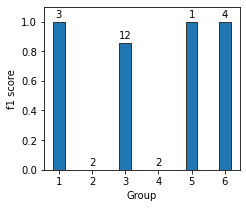

In [21]:
# Define general properties
x = np.arange(1, 7)  # the label locations
width = 0.35  # the width of the bars

# Calculate f1 score for compound group 
f1 = []
for lab, group in comparison.groupby('Group'):
    ya = group.Class[group.set=='train']
    yb = group.predicted[group.set=='train']
    yc = group.Class[group.set=='test']
    yd = group.predicted[group.set=='test']
    
    f1.append([lab, f1_score(ya, yb), f1_score(yc, yd), len(yc)])

f1 = np.array(f1)

# Create figure object and store it in a variable called 'fig'
fig = plt.figure(figsize=(3.5, 3))

# Add axes object to our figure 
ax = fig.add_subplot(111)

# Create bar plots
ax.bar(x, f1[:, 2], width, edgecolor=[0.2, 0.2, 0.2])

# Edit axes
ax.set_xlabel('Group')
ax.set_ylabel('f1 score')
ax.set_xticks(x)
ax.set_ylim(0, 1.1)

# Add labels for number of samples per group
for i in range(len(x)):
    plt.text(x[i], f1[i, 2] + 0.03, 
             int(f1[i, 3]), ha='center')

plt.show()

In [29]:
# Export the results
comparison.to_csv('./Results/Predictions_and_cmpd_group_RF31.csv')